In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize


data = pd.read_csv('buckling_dataset.csv',index_col=0)
df = pd.DataFrame(data)
df.head()

,Rod_OD (mm),Rod_Thickness (mm),Buckling Load Factor (Y1),Mass (kg) (Y2)
Run,,,,
1,20,2,6.883,0.266
2,20,3,8.564,0.377
3,20,4,9.698,0.474
4,25,2,14.336,0.340
5,25,3,18.680,0.488


In [29]:
poly = PolynomialFeatures(degree=2)
X = df[['Rod_OD (mm)', 'Rod_Thickness (mm)']]
X_poly = poly.fit_transform(X)

#Model A: Predicts Buckling Strength
model_buckling = LinearRegression()
model_buckling.fit(X_poly, df['Buckling Load Factor (Y1)'])

#Model B: Predicts Mass
model_mass = LinearRegression()
model_mass.fit(X_poly, df['Mass (kg) (Y2)'])

print("AI Models Trained !")

AI Models Trained !


In [30]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

target_factor = 30.0

def predict_mass(x):
    #x[0] = OD, x[1] = Thickness
    return model_mass.predict(poly.transform([x]))[0]

def constraint_func(x):
    return model_buckling.predict(poly.transform([x]))[0] - target_factor


initial_guess = [30, 3]
bounds = [(20, 40), (2, 4)] #Stay within simulation limits

result = minimize(predict_mass, initial_guess, method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': constraint_func})


print("\nOPTIMIZATION RESULTS: ")
if result.success:
    opt_od = result.x[0]
    opt_thk = result.x[1]
    print(f"Optimal Outer Diameter: {opt_od:.4f} mm")
    print(f"Optimal Wall Thickness: {opt_thk:.2f} mm")
    print(f"Predicted Mass:         {result.fun:.4f} kg")
    print(f"Safety Factor:          {target_factor} (Target Met)")
else:
    print("Optimization Failed.")


OPTIMIZATION RESULTS: 
Optimal Outer Diameter: 32.2280 mm
Optimal Wall Thickness: 2.00 mm
Predicted Mass:         0.4469 kg
Safety Factor:          30.0 (Target Met)


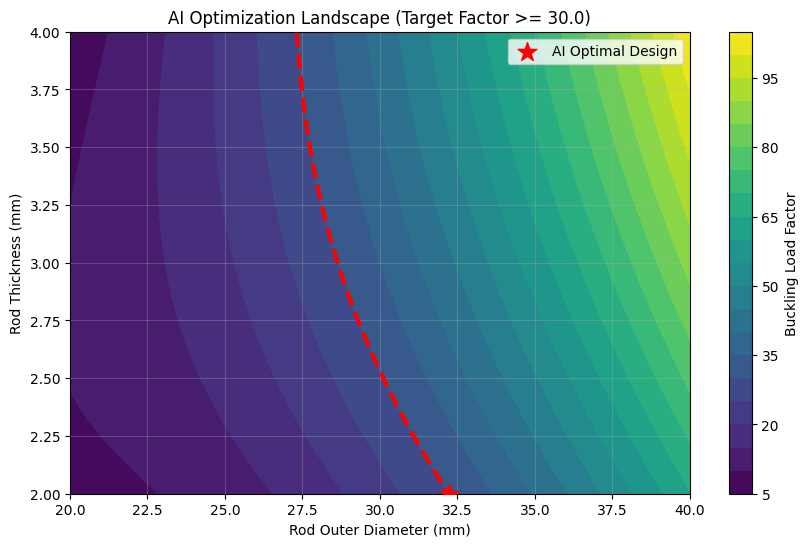

In [31]:
import matplotlib.pyplot as plt

#Visualization:
x_grid = np.linspace(20, 40, 100)
y_grid = np.linspace(2, 4, 100)
X_g, Y_g = np.meshgrid(x_grid, y_grid)
grid_points = np.c_[X_g.ravel(), Y_g.ravel()]
Z_buckling = model_buckling.predict(poly.transform(grid_points)).reshape(X_g.shape)

plt.figure(figsize=(10, 6))
contour = plt.contourf(X_g, Y_g, Z_buckling, levels=20, cmap='viridis')
plt.colorbar(contour, label='Buckling Load Factor')
#Constraint Line (Safety Factor = 30)
plt.contour(X_g, Y_g, Z_buckling, levels=[target_factor], colors='red', linewidths=3, linestyles='dashed')
#Plotting the Optimal Point
plt.scatter(opt_od, opt_thk, color='red', s=200, marker='*', label='AI Optimal Design', zorder=5)
plt.xlabel('Rod Outer Diameter (mm)')
plt.ylabel('Rod Thickness (mm)')
plt.title(f'AI Optimization Landscape (Target Factor >= {target_factor})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('optimization_result.png')
plt.show()